## Pre-test

In [445]:
import matplotlib.pyplot as plt

In [1]:
import numpy as np
m_dimension = 5
m_rows = 20
m_x = np.random.randint(5, size=(m_rows, m_dimension))

u_dimension = 5
u_rows = 7
u_x = np.random.randint(5, size=(u_rows, u_dimension))

In [2]:
m_x.shape

(20, 5)

In [3]:
u_x.shape

(7, 5)

In [4]:
r_x = np.dot(u_x, m_x.T)
r_x.shape

(7, 20)

In [5]:
import faiss
m_index = faiss.IndexFlatIP(m_dimension)
m_index.add(m_x.astype('float32'))

In [6]:
rating, prefer_m_indexs = m_index.search(u_x[0].reshape(-1, u_dimension).astype('float32'), 5)

In [7]:
rating

array([[28., 27., 26., 25., 23.]], dtype=float32)

In [8]:
prefer_m_indexs

array([[14,  2,  5,  4,  1]])

In [9]:
r_x[0][11]

18

## MovieLens Dataset

In [448]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df = pd.io.parsers.read_csv(user_url, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', engine ='python')

In [449]:
print("user:", len(rating_df['user_id'].unique()))
print("movie:", len(rating_df['movie_id'].unique()))

user: 6040
movie: 3706


-----
#### 1) Data Preprocessing

In [450]:
rating_df['time'].quantile(q=0.8, interpolation='nearest')

975768738

In [451]:
train_rating_df = rating_df[rating_df['time'] < 975768738][['user_id', 'movie_id', 'rating']]
test_rating_df = rating_df[rating_df['time'] >= 975768738][['user_id', 'movie_id', 'rating']]

In [452]:
from surprise import Dataset, Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df=train_rating_df, reader=reader)
train_data = data.build_full_trainset()

-----

### 1. Latent Factor Model
#### 1) Default indexing

In [453]:
from surprise import SVD
from surprise import accuracy

algo = SVD(n_factors=50)
algo.fit(train_data)

In [454]:
u_dimension = algo.pu.shape[0]
m_dimension = algo.qi.shape[0]

In [455]:
m_index = faiss.IndexFlatIP(algo.n_factors)
m_index.add(algo.qi.astype('float32'))

In [456]:
rating, prefer_m_indexs = m_index.search(algo.pu[0].reshape(-1, algo.n_factors).astype('float32'), 5)

In [457]:
rating

array([[0.3983068 , 0.34619325, 0.3440023 , 0.3175459 , 0.31554127]],
      dtype=float32)

In [458]:
prefer_m_indexs  # SVD inner indexed ids

array([[ 625,  817, 1268,  849,   53]])

-----
#### 2) Indexing with ids

In [459]:
movie_ids = []
for inner_movie_id in algo.trainset.all_items():
    raw_movie_id = algo.trainset.to_raw_iid(iiid=inner_movie_id)
    movie_ids.append(raw_movie_id)

In [460]:
m_index = faiss.IndexFlatIP(algo.n_factors)
m_index = faiss.IndexIDMap2(m_index)
m_index.add_with_ids(algo.qi.astype('float32'), np.array(movie_ids))

In [461]:
inner_user_id = algo.trainset.to_inner_uid(635)  # userid 635인 유저의 matrix index
user_latent_vector = algo.pu[inner_user_id].reshape(-1, algo.n_factors).astype('float32')  # 해당 유저의 latent vector
rating, prefer_m_ids = m_index.search(user_latent_vector, 5)

In [462]:
rating

array([[0.3983068 , 0.34619325, 0.3440023 , 0.3175459 , 0.31554127]],
      dtype=float32)

In [463]:
prefer_m_ids  # real movie ids

array([[2710,  671, 1914, 2393,  260]])

-----

#### 3) Top k MAP

In [464]:
user_watch_movielist_dict = train_rating_df.groupby('user_id')['movie_id'].apply(lambda x : set(x.tolist())).to_dict()

In [465]:
user_recommendations = {}
for user in test_rating_df['user_id'].unique():
    try:
        inner_user_id = algo.trainset.to_inner_uid(user)
        user_latent_vector = algo.pu[inner_user_id].reshape(-1, algo.n_factors).astype('float32')
        _, prefer_m_ids = m_index.search(user_latent_vector, 200)
        user_recommendations[user] = prefer_m_ids.reshape(-1,).tolist()
    except:
#         print("User", user, "has no history. exclude for recommendation")
        continue

In [466]:
# except movie id already watched
min_rec_no = 200
for user in user_recommendations:
    user_recommendations[user] = [movie_id for movie_id in user_recommendations[user] if movie_id not in user_watch_movielist_dict[user]]
    rec_no = len(user_recommendations[user])
    if min_rec_no > rec_no:
        min_rec_no = rec_no
print("min rec result no:", min_rec_no)

min rec result no: 25


In [467]:
def get_map_topk(user_recommendations, user_testset, k):
    user_metric = []
    for user in user_recommendations:
        test_list = user_testset[user]
        reco_list = user_recommendations[user][:k]
        user_metric.append((user, reco_list, test_list))
  
    precision_list = []
    for user in user_metric:
        predictive_values = user[1]
        actual_values = user[2]
        tp = [pv for pv in predictive_values if pv in actual_values]
        precision = len(tp) / len(predictive_values)
        precision_list.append(precision)
    return sum(precision_list) / len(precision_list)

In [468]:
user_testset = test_rating_df.groupby('user_id')['movie_id'].apply(lambda x: set(x.tolist())).to_dict()
get_map_topk(user_recommendations, user_testset, 20)

0.11981627296587906

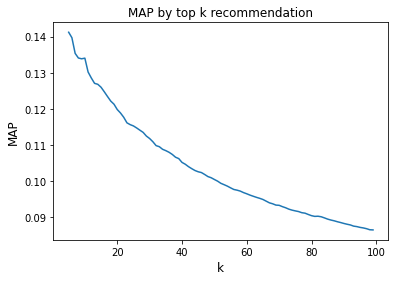

In [469]:
k_param_list = []
map_list = []
for k in range(5, 100):
    map_list.append(get_map_topk(user_recommendations, user_testset, k))
    k_param_list.append(k)

plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

-----
### 2. DeepMF Model

#### 1) Feature Engineering for Vectorize

##### [1] User profiling

In [388]:
def age_bucketize(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_df['age_bucket'] = user_df['age'].apply(lambda x: age_bucketize(x))
user_df['age_bucket'].value_counts()

20         2096
30         1193
10         1103
50          876
40          550
outlier     222
Name: age_bucket, dtype: int64

In [389]:
gender_list = user_df['gender'].unique()
gender_index = {}
for idx, gender in enumerate(gender_list):
    gender_index[gender] = idx
print(gender_index)

{'F': 0, 'M': 1}


In [390]:
age_list = user_df['age_bucket'].unique()
age_index = {}
for idx, age in enumerate(age_list):
    age_index[age] = idx
print(age_index)

{'outlier': 0, '50': 1, '20': 2, '40': 3, '30': 4, '10': 5}


In [391]:
occupation_list = user_df['occupation'].unique()
occupation_index = {}
for idx, occupation in enumerate(occupation_list):
    occupation_index[occupation] = idx
print(occupation_index)

{10: 0, 16: 1, 15: 2, 7: 3, 20: 4, 9: 5, 1: 6, 12: 7, 17: 8, 0: 9, 3: 10, 14: 11, 4: 12, 11: 13, 8: 14, 19: 15, 2: 16, 18: 17, 5: 18, 13: 19, 6: 20}


-----
##### [2] Movie profiling

In [392]:
movie_df['main_genre'] = movie_df['genre'].apply(lambda x: x.split("|")[0])
movie_df['parsed_genre'] = movie_df['genre'].apply(lambda x: x.split("|"))
movie_df['released_year_area'] = movie_df['title'].apply(lambda x: x[-5:-2]+"0")
movie_df = movie_df[['movie_id', 'main_genre', 'parsed_genre', 'released_year_area']]

In [393]:
unique_genre = set([y for x in movie_df['parsed_genre'].tolist() for y in x])
genre_index = {}
for idx, genre in enumerate(unique_genre):
    genre_index[genre] = idx
print(genre_index)

{'Western': 0, 'Animation': 1, 'Horror': 2, 'Thriller': 3, 'Adventure': 4, 'Drama': 5, 'Documentary': 6, 'Comedy': 7, 'War': 8, 'Romance': 9, 'Musical': 10, 'Mystery': 11, 'Film-Noir': 12, 'Fantasy': 13, 'Sci-Fi': 14, 'Action': 15, 'Crime': 16, "Children's": 17}


In [394]:
year_list = movie_df['released_year_area'].unique()
year_index = {}
for idx, year in enumerate(year_list):
    year_index[year] = idx
print(year_index)

{'1990': 0, '1970': 1, '1980': 2, '1960': 3, '1930': 4, '1940': 5, '1950': 6, '1920': 7, '1910': 8, '2000': 9}


-----
##### [3] Movie embedding (Meta-Prod2Vec)

In [395]:
movie_meta_dict = movie_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()

In [396]:
user_watch_list = rating_df.groupby('user_id')['movie_id'].apply(lambda x: x.tolist())

In [397]:
movie2vec_dataset = []
for movie_list in user_watch_list:
    meta_list = []
    for movie_id in movie_list:
        word_meta_1 = "movie_id:" + str(movie_id)
        word_meta_2 = "year:" + movie_meta_dict['released_year_area'][movie_id]
        word_meta_3 = "genre:" + movie_meta_dict['main_genre'][movie_id]
        meta_list.append(word_meta_1)
        meta_list.append(word_meta_2)
        meta_list.append(word_meta_3)
    movie2vec_dataset.append(meta_list)

In [398]:
from gensim.models import Word2Vec

# model = Word2Vec(movie2vec_dataset,
#                  size=100,
#                  window=6,
#                  sg=1,
#                  hs=0,
#                  negative=20,
#                  min_count=1,
#                  iter=20)

In [399]:
# model.save('movie2vec.model')

In [400]:
model = Word2Vec.load('movie2vec.model')

In [401]:
print(len(rating_df['movie_id'].unique()))
print(model.wv.vectors.shape)

3706
(3734, 100)


-----
##### [4] Movie Vector Transform

In [402]:
movie_df = movie_df[['movie_id', 'released_year_area', 'main_genre', 'parsed_genre']]
movie_df['released_year_area'] = movie_df['released_year_area'].apply(lambda x: year_index[x])
movie_df['parsed_genre'] = movie_df['parsed_genre'].apply(lambda x: [genre_index[genre] for genre in x])
movie_df['main_genre'] = movie_df['main_genre'].apply(lambda x: genre_index[x])

In [403]:
movie_df.head()

,movie_id,released_year_area,main_genre,parsed_genre
0,1,0,1,"[1, 17, 7]"
1,2,0,4,"[4, 17, 13]"
2,3,0,7,"[7, 9]"
3,4,0,7,"[7, 5]"
4,5,0,7,[7]


In [404]:
year_area_dimension = len(year_index)
genre_dimension = len(genre_index)
def get_sparse_vector(movie_id, released_year_area, main_genre, parsed_genre):
    year_vector = np.zeros(year_area_dimension)
    year_vector[released_year_area] = 1
    main_genre_vector = np.zeros(genre_dimension)
    main_genre_vector[main_genre] = 1
    parsed_genre_vector = np.zeros(genre_dimension)
    for genre in parsed_genre:
        parsed_genre_vector[genre] = 1
    try:
        meta2prod_embedding_vector = model.wv.get_vector('movie_id:' + str(movie_id))
    except:
        meta2prod_embedding_vector = np.zeros(100)
    return np.concatenate((year_vector, main_genre_vector, parsed_genre_vector, meta2prod_embedding_vector), axis=None)

In [405]:
movie_df['sparse_vector'] = movie_df.apply(lambda x: get_sparse_vector(x['movie_id'], x['released_year_area'], x['main_genre'], x['parsed_genre']), axis=1)

In [406]:
movie_df = movie_df[['movie_id', 'sparse_vector']]
movie_df.head()

,movie_id,sparse_vector
0,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


-----
##### [5] User Vector Transform

In [407]:
user_df = user_df[['user_id', 'gender', 'age_bucket', 'occupation']]
user_df['gender'] = user_df['gender'].apply(lambda x: gender_index[x])
user_df['age_bucket'] = user_df['age_bucket'].apply(lambda x: age_index[x])
user_df['occupation'] = user_df['occupation'].apply(lambda x: occupation_index[x])

In [408]:
user_df.head()

,user_id,gender,age_bucket,occupation
0,1,0,0,0
1,2,1,1,1
2,3,1,2,2
3,4,1,3,3
4,5,1,2,4


In [409]:
gender_dimension = len(gender_index)
age_dimension = len(age_index)
occupation_dimension = len(occupation_index)
def get_user_sparse_vector(user_id, gender, age, occupation):
    gender_vector = np.zeros(gender_dimension)
    gender_vector[gender] = 1
    age_vector = np.zeros(age_dimension)
    age_vector[age] = 1
    occupation_vector = np.zeros(occupation_dimension)
    occupation_vector[occupation] = 1
    return np.concatenate((gender_vector, age_vector, occupation_vector), axis=None)

In [410]:
user_df['user_sparse_vector'] = user_df.apply(lambda x: get_user_sparse_vector(x['user_id'], x['gender'], x['age_bucket'], x['occupation']), axis=1)
user_df = user_df[['user_id', 'user_sparse_vector']]
user_df.head()

,user_id,user_sparse_vector
0,1,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,2,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,5,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


#### 2) DeepMF Model

-----
##### [1] Make Trainset

In [411]:
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [412]:
# # 유저가 해당 시점(time)에서 최근 시청한 영화중 4점 이상을 준 리스트만 5개 추출
# def recent_5_liked_mid(user_id, movie_id, rating, time):
#     subset_df = rating_df[rating_df['user_id']==user_id]
#     sorted_df = subset_df.sort_values('time')
#     filtered_df = sorted_df[(sorted_df['time'] <= time) & (sorted_df['movie_id'] != movie_id) & (sorted_df['rating'] > 3)]
#     filtered_list = filtered_df['movie_id'].tolist()
#     if len(filtered_list) > 4:
#         return filtered_list[-5:]
#     else:
#         return filtered_list

# # user profile feature
# rating_df['recent_5_liked_mid'] = rating_df.apply(lambda x: recent_5_liked_mid(x['user_id'], x['movie_id'], x['rating'],  x['time']), axis=1)

In [413]:
# # 시간 단축용
# rating_df.to_csv("recent_liked_data.csv", index=False, header=True)

In [414]:
import ast

rating_df = pd.read_csv("recent_liked_data.csv")
rating_df['recent_5_liked_mid'] = rating_df['recent_5_liked_mid'].apply(lambda x: ast.literal_eval(x))

In [415]:
# user profile feature: 유저가 최근 본 5개의 좋아하는 영화의 벡터를 average pooling
mid_vector_dict = movie_df.set_index('movie_id')[['sparse_vector']].to_dict()
mid_vector_dimension = movie_df['sparse_vector'][0].shape[0]
def average_pooling(mid_list):
    if mid_list == []:
        return np.zeros(mid_vector_dimension)
    return np.average(np.array([mid_vector_dict['sparse_vector'][mid] for mid in mid_list]), axis=0)

rating_df['averaged_context_vector'] = rating_df['recent_5_liked_mid'].apply(lambda x: average_pooling(x))

In [416]:
# user input vector 생성 - 앞서 추출한 2개의 profile 벡터를 concatenate
uid_vector_dict = user_df.set_index('user_id')[['user_sparse_vector']].to_dict()
def concat_user_feature(x):
    return np.concatenate((uid_vector_dict['user_sparse_vector'][x['user_id']], x['averaged_context_vector']), axis=None)

rating_df['user_input'] = rating_df.apply(lambda x: concat_user_feature(x), axis=1)

In [417]:
# movie input vector 생성
rating_df['movie_input'] = rating_df['movie_id'].apply(lambda x: mid_vector_dict['sparse_vector'][x])

In [418]:
rating_df = rating_df[['user_id', 'movie_id', 'time', 'rating', 'user_input', 'movie_input']]
train_rating_df = rating_df[rating_df['time'] < 975768738]
test_rating_df = rating_df[rating_df['time'] >= 975768738]

-----
##### [2] Training

In [337]:
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Input, Dense, concatenate, Flatten
from keras.optimizers import Adam

In [480]:
class DeepMF:
    def __init__(self, learning_rate, epochs, batch_size, user_input_dim, movie_input_dim):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.user_input_dim = user_input_dim
        self.movie_input_dim = movie_input_dim
        self.model = self.deep_mf()

    def deep_mf(self):
        optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)

        # user input
        user_input = layers.Input(shape=(self.user_input_dim,))
        user_hidden_layer = layers.Dense(200, activation='relu')(user_input)
        user_embedding1 = layers.Dense(100, activation='relu')(user_hidden_layer)
        user_embedding = layers.Dense(100, activation='relu')(user_embedding1)
        user_vec = layers.Flatten(name='user_vec')(user_embedding)

        # movie input
        movie_input = layers.Input(shape=(self.movie_input_dim,))
        movie_hidden_layer = layers.Dense(200, activation='relu')(movie_input)
        movie_embedding1 = layers.Dense(100, activation='relu')(movie_hidden_layer)
        movie_embedding = layers.Dense(100, activation='relu')(movie_embedding1)
        movie_vec = layers.Flatten(name='movie_vec')(movie_embedding)

        # concatenate : dot product
        dot_vec = layers.dot([user_vec, movie_vec], axes=1, name='dot_vec')
        model = Model(inputs=[user_input, movie_input], outputs=dot_vec)
        model.compile(loss='mean_squared_error',
                      optimizer=optimizer,
                      metrics=['mse'])
        return model

    def fit(self, user_input, movie_input, rating):
        self.model.fit([user_input, movie_input], rating, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2)

    def print_performance(self, user_input, movie_input, rating):
        performance_test = self.model.evaluate([user_input, movie_input], rating, batch_size=self.batch_size)
        print('Test MSE ->', performance_test[0])

In [339]:
user_input_dim = rating_df['user_input'][0].shape[0]
movie_input_dim = rating_df['movie_input'][0].shape[0]
deep_mf_model = DeepMF(learning_rate=0.001, epochs=10, batch_size=2000, user_input_dim=user_input_dim, movie_input_dim=movie_input_dim)

In [340]:
x_train_user_input = np.array(train_rating_df['user_input'].tolist())
x_train_movie_input = np.array(train_rating_df['movie_input'].tolist())
x_test_user_input = np.array(test_rating_df['user_input'].tolist())
x_test_movie_input = np.array(test_rating_df['movie_input'].tolist())
y_train = np.array(train_rating_df['rating'].tolist())
y_test = np.array(test_rating_df['rating'].tolist())

In [481]:
deep_mf_model.fit(x_train_user_input, x_train_movie_input, y_train)
deep_mf_model.print_performance(x_test_user_input, x_test_movie_input, y_test)

Epoch 1/10
321/321 [==============================] - 3s 10ms/step - loss: 0.7695 - mse: 0.7695 - val_loss: 1.0614 - val_mse: 1.0614
Epoch 2/10
321/321 [==============================] - 3s 9ms/step - loss: 0.7655 - mse: 0.7655 - val_loss: 1.0597 - val_mse: 1.0597
Epoch 3/10
321/321 [==============================] - 3s 9ms/step - loss: 0.7604 - mse: 0.7604 - val_loss: 1.0748 - val_mse: 1.0748
Epoch 4/10
321/321 [==============================] - 3s 9ms/step - loss: 0.7574 - mse: 0.7574 - val_loss: 1.0656 - val_mse: 1.0656
Epoch 5/10
321/321 [==============================] - 3s 10ms/step - loss: 0.7541 - mse: 0.7541 - val_loss: 1.0637 - val_mse: 1.0637
Epoch 6/10
321/321 [==============================] - 3s 9ms/step - loss: 0.7500 - mse: 0.7500 - val_loss: 1.1129 - val_mse: 1.1129
Epoch 7/10
321/321 [==============================] - 3s 9ms/step - loss: 0.7463 - mse: 0.7463 - val_loss: 1.0803 - val_mse: 1.0803
Epoch 8/10
321/321 [==============================] - 3s 10ms/step - loss:

#### 3) Top k MAP

-----
##### [1] Indexing with ids

In [419]:
user_latent_vector = deep_mf_model.model.get_layer("user_vec").output
movie_latent_vector = deep_mf_model.model.get_layer("movie_vec").output
ul = Model(inputs=deep_mf_model.model.input, outputs=user_latent_vector)
ml = Model(inputs=deep_mf_model.model.input, outputs=movie_latent_vector)

In [420]:
# user latent vector
user_test_latent_vector = ul.predict([x_test_user_input[0].reshape(1,-1), x_test_movie_input[0].reshape(1,-1)])
user_test_latent_vector

array([[0.        , 0.        , 0.        , 0.2118307 , 0.39384124,
        0.44420186, 0.68785644, 0.        , 0.18666789, 0.        ,
        0.08292237, 0.        , 0.14650297, 0.07845943, 0.        ,
        0.3322051 , 0.        , 0.        , 0.51575035, 0.        ,
        0.        , 0.        , 0.        , 0.39354   , 0.1441606 ,
        0.23438841, 0.19207948, 0.40197614, 0.        , 0.16835178,
        0.26801333, 0.        , 0.4057256 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.6913568 , 0.05967681,
        0.        , 0.7048268 , 0.        , 0.0596898 , 0.        ,
        0.00784562, 0.0749912 , 0.5008796 , 0.        , 0.        ,
        0.3745381 , 0.28445244, 0.        , 0.02602228, 0.12675786,
        0.17107771, 0.        , 0.        , 0.        , 0.        ,
        0.1847147 , 0.        , 0.24969955, 0.2765935 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.12705211,
        0.02005998, 0.11206055, 0.29233396, 0.23

In [421]:
# movie latent vectors in trainset
dummy_shape = (np.array(movie_df['sparse_vector'].tolist()).shape[0], user_input_dim)
movie_latent_vectors = ml.predict([np.zeros(dummy_shape), np.array(movie_df['sparse_vector'].tolist())])

In [422]:
embedding_dimension = 100

movie_ids = []
for index, row in movie_df.iterrows():
    movie_ids.append(row['movie_id'])
    
m_index = faiss.IndexFlatIP(embedding_dimension)
m_index = faiss.IndexIDMap2(m_index)
m_index.add_with_ids(movie_latent_vectors, np.array(movie_ids))

rating, prefer_m_indexs = m_index.search(user_test_latent_vector, 5)

In [423]:
rating

array([[5.052394 , 4.9196625, 4.8863444, 4.883404 , 4.871982 ]],
      dtype=float32)

In [424]:
prefer_m_indexs

array([[  50,  608,  527,  922, 1237]])

-----
##### [2] Get MAP

In [425]:
def get_latest_context_vector(x):
    return x.sort_values('time')['user_input'].index[-1]
latest_context_vector_index = rating_df.groupby('user_id').apply(lambda x: get_latest_context_vector(x))

In [434]:
user_watch_movielist_dict = train_rating_df.groupby('user_id')['movie_id'].apply(lambda x : set(x.tolist())).to_dict()
dummy_shape = (1, movie_input_dim)
train_user_set = set(train_rating_df['user_id'].unique().tolist())

user_recommendations = {}
for user in test_rating_df['user_id'].unique():
    if user in train_user_set:
        user_latent_vector = ul.predict([rating_df.iloc[latest_context_vector_index[user], -2].reshape(1,-1), np.zeros(dummy_shape)])
        _, prefer_m_ids = m_index.search(user_latent_vector, 200)
        user_recommendations[user] = prefer_m_ids.reshape(-1,).tolist()
    else:
#         print("User", user, "has no history. exclude for recommendation")
        continue

In [437]:
min_rec_no = 200
for user in user_recommendations:
    user_recommendations[user] = [movie_id for movie_id in user_recommendations[user] if movie_id not in user_watch_movielist_dict[user]]
    rec_no = len(user_recommendations[user])
    if min_rec_no > rec_no:
        min_rec_no = rec_no
print("min rec result no:", min_rec_no)

min rec result no: 26


In [439]:
def get_map_topk(user_recommendations, user_testset, k):
    user_metric = []
    for user in user_recommendations:
        test_list = user_testset[user]
        reco_list = user_recommendations[user][:k]
        user_metric.append((user, reco_list, test_list))
  
    precision_list = []
    for user in user_metric:
        predictive_values = user[1]
        actual_values = user[2]
        tp = [pv for pv in predictive_values if pv in actual_values]
        precision = len(tp) / len(predictive_values)
        precision_list.append(precision)
    return sum(precision_list) / len(precision_list)

user_testset = test_rating_df.groupby('user_id')['movie_id'].apply(lambda x: set(x.tolist())).to_dict()
get_map_topk(user_recommendations, user_testset, 20)

0.13079615048118967

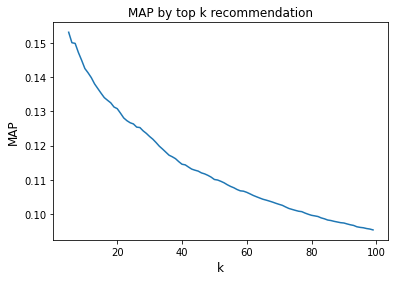

In [447]:
k_param_list = []
map_list = []
for k in range(5, 100):
    map_list.append(get_map_topk(user_recommendations, user_testset, k))
    k_param_list.append(k)

plt.plot(k_param_list, map_list)
plt.title('MAP by top k recommendation')
plt.ylabel('MAP', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.show()

- SVD 대비 5~7% 정도 성능 향상 (MAP 기준 0.14 -> 0.15)

-----
### 3. Faiss With Large Dataset

In [470]:
embedding_vector_1m = ml.predict([x_train_user_input, x_train_movie_input])

In [471]:
m_index = faiss.IndexFlatIP(100)
m_index.add(embedding_vector_1m)

In [476]:
import time

# start_time을 체크
start_time = time.time()
for i in range(1000):
    rating, prefer_m_indexs = m_index.search(user_test_latent_vector, 5)

print("---{}s seconds---".format(time.time()-start_time))

---29.67272925376892s seconds---


- 1백만 개의 벡터를 인덱싱 (1M, 100) 차원
- dot product 연산 시, 0.03 time per transaction (Local PC Memory 32GB, CPU mode)
- 메모리 큰 서버 스펙에 GPU 모드로 하면 0.01 이하로 될 것으로 추정

-----
### 4. DeepMF + Faiss + Yogiyo Dataset

-----
### 5. GCMC Modeling